In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
bom_movie_gross = pd.read_csv("../data/bom.movie_gross.csv.gz")

In [6]:
imdb_name_basics = pd.read_csv("../data/imdb.name.basics.csv.gz")

In [7]:
imdb_title_akas = pd.read_csv("../data/imdb.title.akas.csv.gz")

In [8]:
imdb_title_basics = pd.read_csv("../data/imdb.title.basics.csv.gz")

In [9]:
imdb_title_crew = pd.read_csv("../data/imdb.title.crew.csv.gz")

In [10]:
imdb_title_principals = pd.read_csv("../data/imdb.title.principals.csv.gz")

In [11]:
imdb_title_ratings = pd.read_csv("../data/imdb.title.ratings.csv.gz")

In [12]:
rt_movie_info = pd.read_csv("../data/rt.movie_info.tsv.gz", sep='\t')

In [13]:
# rt_reviews = pd.read_csv(data_directory+'rt.reviews.tsv.gz', delimiter = '\t', encoding = 'cp437')

In [14]:
tmdb_movies = pd.read_csv("../data/tmdb.movies.csv.gz")

In [15]:
tn_movie_budgets = pd.read_csv("../data/tn.movie_budgets.csv.gz")

In [16]:
%matplotlib inline

In [17]:
import pandas as pd
data_directory = '../Data/'  
# df_bom = pd.read_csv(data_directory+'bom.movie_gross.csv.gz') #Source: Box Office Mojo
# df_rt_movies = pd.read_csv(data_directory+'rt.movie_info.tsv.gz', delimiter = '\t') #Source: Rotten tomatoes
# df_rt_reviews = pd.read_csv(data_directory+'rt.reviews.tsv.gz', delimiter = '\t', encoding = 'cp437') #Source: Rotten tomatoes 
df_imdb_basics = pd.read_csv(data_directory+'imdb.title.basics.csv.gz') # Source: IMDB
df_imdb_ratings = pd.read_csv(data_directory+'imdb.title.ratings.csv.gz') # Source: IMDB
df_mdb_ratings = pd.read_csv(data_directory+'tmdb.movies.csv.gz') # Source: MovieDB
df_mdb_revenues = pd.read_csv(data_directory+'tn.movie_budgets.csv.gz') # Source: MovieDB

In [18]:
imdb_name_basics.loc[imdb_name_basics["primary_name"] == "Joseph Gordon-Levitt"]

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
4260,nm0330687,Joseph Gordon-Levitt,1981.0,NaN,"actor,producer,soundtrack","tt1375666,tt1276104,tt1306980,tt2229499"


In [19]:
imdb_title_ratings.loc[imdb_title_ratings["tconst"] == "tt1375666"]

,tconst,averagerating,numvotes
63498,tt1375666,8.8,1841066


# Creating Lists and Graphs and Things

Instead of using the arbitrary 100000 we will use 25%... 

So I want to first sort by "averagerating", because if we're going to claim to know what type of movie Microsoft Film Studios should make like some kind of mystic, we may as tell them we aim to be compared to the best of the best.  But they also need to have a certain amount of weight, or proof which comes for better or worse throgh "numvotes", because strength in numbers. 

# Plot average rating over the y-axis, movies with greater "numvotes" have a more opaque color whereas the movies with less are transparent. X-Axis displays names? vvvv

In [20]:
# The function cleans the two Movie DB dataframes
def df_clean(data_frame, release_date_column, movie_title_column):
    data_frame.drop_duplicates(keep = 'first', inplace = True)
    if data_frame[release_date_column].dtypes == 'int64':
        data_frame[release_date_column] = pd.to_datetime(data_frame[release_date_column], format = '%Y').dt.to_period("Y") # Assume that movies released in the same month of the same year are the same.
    else:
        data_frame[release_date_column] = pd.to_datetime(data_frame[release_date_column]).dt.to_period("Y") # Assume that movies released in the same month of the same year are the same.
    data_frame[movie_title_column] = [" ".join(title.upper().split()) for title in data_frame[movie_title_column]] # Remove whitespaces
    data_frame[movie_title_column] = [title.replace('Â', "'") for title in data_frame[movie_title_column]] 
    data_frame[movie_title_column] = [title.replace('#', '') for title in data_frame[movie_title_column]] 
    data_frame[movie_title_column] = [title.replace('"', '') for title in data_frame[movie_title_column]]               
    data_frame.drop_duplicates([movie_title_column, release_date_column], keep = False, inplace = True)
    data_frame.sort_values(by = [release_date_column, movie_title_column], ascending = [False, True], inplace = True)
    data_frame.rename(columns={release_date_column: 'release_date', movie_title_column: 'title'}, inplace = True)
    return data_frame

In [21]:
# Merge Movie DB dataframes
df_mdb_ratings.drop('Unnamed: 0', axis = 1, inplace = True) # This is an extra index column
df_mdb_ratings = df_clean(df_mdb_ratings, 'release_date', 'title')
df_mdb_revenues = df_clean(df_mdb_revenues, 'release_date', 'movie')
df_mdb = pd.merge(df_mdb_ratings, df_mdb_revenues, how = 'outer', \
              left_on = ['title', 'release_date'], \
              right_on = ['title', 'release_date'], \
              indicator = True, validate="one_to_one", \
              sort = True)


In [22]:
# Merge IMDB dataframes
df_imdb_basics = df_clean(df_imdb_basics, 'start_year', 'primary_title')
df_imdb = pd.merge(df_imdb_basics, df_imdb_ratings, how = 'outer', \
              on = 'tconst', \
              indicator = True, validate="one_to_one")

In [23]:
# Merge Movie DB and IMDB dataframes
df = pd.merge(df_imdb.drop(columns = '_merge'), df_mdb.drop(columns = '_merge'), how = 'outer', \
              left_on = ['title', 'release_date'], \
              right_on = ['title', 'release_date'], \
              indicator = True, validate="many_to_one", \
              sort = True)
df_merged = df.loc[df._merge == 'both']

In [24]:
df_merged = df.loc[df._merge == 'both']


# Took out any movies that didn't have rating votes in either IMDB or MoviesDB

In [25]:
df_clean = pd.read_csv("export_df_clean.csv")

In [26]:
df_clean.columns

Index(['title', 'release_year', 'genres', 'averagerating', 'numvotes',
       'genre_ids', 'popularity', 'vote_average', 'vote_count',
       'release_year_month', 'production_budget', 'domestic_gross',
       'worldwide_gross', '_merge'],
      dtype='object')

In [27]:
# df_clean["release_year_month"].map(lambda x: len(x.split())).head()

month = []
for movies in df_clean["release_year_month"]:
    if isinstance(movies, str):
        month.append(movies[5:7])
    else:
        month.append("00")
df_clean["month"] = month

In [28]:
df_clean.describe()

,release_year,averagerating,numvotes,popularity,vote_average,vote_count
count,85455.000000,73941.000000,7.394100e+04,25299.000000,25299.000000,25299.000000
mean,2014.173401,6.331804,3.571793e+03,3.044182,5.979371,178.572750
std,2.930876,1.475130,3.059231e+04,4.264437,1.865593,913.083646
min,1930.000000,1.000000,5.000000e+00,0.600000,0.000000,1.000000
25%,2012.000000,5.500000,1.400000e+01,0.600000,5.000000,1.000000
50%,2014.000000,6.500000,4.900000e+01,1.322000,6.000000,5.000000
75%,2016.000000,7.400000,2.840000e+02,3.491000,7.000000,25.000000
max,2020.000000,10.000000,1.841066e+06,80.773000,10.000000,22186.000000


In [29]:
df_watched = df_clean.loc[(df_clean["numvotes"] >= 284) & (df_clean["vote_count"] >= 25)]
#Removed all but the top 25% of voted on movies...

In [30]:
df_watched.columns

Index(['title', 'release_year', 'genres', 'averagerating', 'numvotes',
       'genre_ids', 'popularity', 'vote_average', 'vote_count',
       'release_year_month', 'production_budget', 'domestic_gross',
       'worldwide_gross', '_merge', 'month'],
      dtype='object')

In [31]:
df_watched_year = df_clean.loc[(df_clean["release_year"] >= 2010)]

In [32]:
sum(df_watched_year["release_year"] == 2019)
#2010 7992
#2011 8721
#2012 8920
#2013 9443
#2014 9756
#2015 9820
#2016 9929
#2017 9955
#2018 8501


2208

In [33]:

total_movies_released = pd.Series([7992,8721,8920,9443,9756,9820,9929,9955,8501]) 

# Create the Index 
index_ = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018] 
  
# set the index 
total_movies_released.index = index_ 



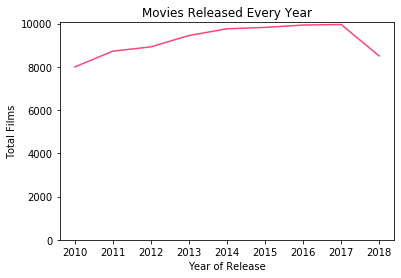

In [34]:
ax = sns.lineplot(total_movies_released.index, total_movies_released.values, color="#ff457a")
ax.set(xlabel='Year of Release', ylabel='Total Films')
ax.set_title("Movies Released Every Year")
ax.set_ylim(bottom = 0)
plt.show()

In [35]:
df_watched

,title,release_year,genres,averagerating,numvotes,genre_ids,popularity,vote_average,vote_count,release_year_month,production_budget,domestic_gross,worldwide_gross,_merge,month
36,(DIS)HONESTY: THE TRUTH ABOUT LIES,2015.0,"Documentary,Drama,News",7.5,1831.0,[99],1.705,7.1,32.0,2015-05,NaN,NaN,NaN,both,05
88,1,2013.0,"Documentary,History,Sport",8.0,3452.0,[99],6.013,7.4,53.0,2013-09,NaN,NaN,NaN,both,09
99,1 CHANCE 2 DANCE,2014.0,"Drama,Family",4.9,486.0,[],2.005,5.8,32.0,2014-01,NaN,NaN,NaN,both,01
108,1 MILE TO YOU,2017.0,"Drama,Romance,Sport",6.3,1865.0,"[18, 10749]",6.497,6.6,103.0,2017-04,NaN,NaN,NaN,both,04
137,10 CLOVERFIELD LANE,2016.0,"Drama,Horror,Mystery",7.2,260383.0,"[53, 878, 18]",17.892,6.9,4629.0,2016-03,"$5,000,000","$72,082,999","$108,286,422",both,03
170,"10,000 SAINTS",2015.0,"Comedy,Drama,Music",5.9,4938.0,"[35, 18, 10402]",6.474,5.9,95.0,2015-08,NaN,NaN,NaN,both,08
173,10.0 EARTHQUAKE,2014.0,"Action,Adventure,Drama",3.5,1374.0,"[18, 12, 28]",4.277,4.1,41.0,2014-10,NaN,NaN,NaN,both,10
188,100 DEGREES BELOW ZERO,2013.0,"Action,Adventure,Drama",2.5,1798.0,"[28, 878]",4.376,3.5,46.0,2013-04,NaN,NaN,NaN,both,04
199,100 STREETS,2016.0,Drama,5.7,3338.0,[18],7.317,6.2,91.0,2016-06,NaN,NaN,NaN,both,06
249,10X10,2018.0,Thriller,5.0,5194.0,"[53, 53]",13.334,5.2,218.0,2018-04,NaN,NaN,NaN,both,04


In [36]:
temp = df_watched.groupby(['month'])['genres'].sum()

In [37]:
data = []
tempoary = []
for items in temp.iteritems():
    data.append(items[1].count("Animation")) 
ser = pd.Series(data) 
ser = ser.rename({0: "Jan", 1:"Feb", 2:"Mar", 3:"Apr",4:"May",5:"June",6:"July", 7:"Aug", 8:"Sep", 9:"Oct", 10:"Nov", 11:"Dec"})
print(sum(ser))


#Animation Total is 185
#Horror is 619
#Action is 894
#Documentary is 312
#Thriller is 733
#Romance 525
#Comedy 1225
#Sport 85
#Adventure 565
#Sci-287


185


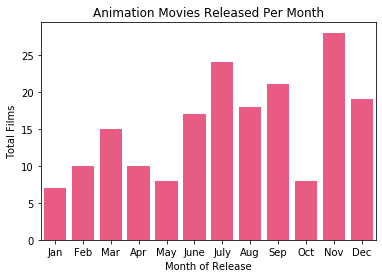

In [47]:
#Graph of genre_target by month
genresreleases = sns.barplot(ser.index, ser.values, color="#ff457a")
genresreleases.set(xlabel='Month of Release', ylabel='Total Films')
genresreleases.set_title("Animation Movies Released Per Month")
plt.show()

In [39]:
#sum of all the movies genres
genre_movies_released = pd.Series([185,619,894,312,733,525,1225,85,565,287,238,576,319,142,1908]) 

# Create the Index 
genre_movies_released_index_ = ["Animation", "Horror", "Action", "Documentary", "Thriller", "Romance", "Comedy", "Sport", "Adventure", "Sci-Fi", "Fantasy", "Crime", "Biography", "Music", "Drama"] 
  
# set the index 
genre_movies_released.index = genre_movies_released_index_ 



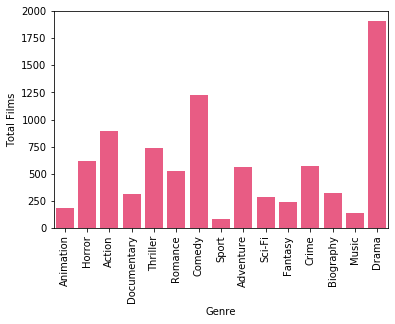

In [40]:
#Graph of genre_target 
genresreleasestotal = sns.barplot(genre_movies_released.index, genre_movies_released.values, color="#ff457a")
genresreleasestotal.set(xlabel='Genre', ylabel='Total Films')
plt.xticks(rotation=90)
# ax.set_ylim(top=1600)
plt.show()

In [50]:
sum(df_watched["month"].value_counts())

3861

In [42]:
total_movies_month = df_watched["month"].value_counts()

In [43]:
total_movies_month = total_movies_month.sort_index()

In [44]:
#Renaming X-Axis for legibility
total_movies_month = total_movies_month.rename({"01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr", "05":"May", "06":"June", "07":"July","08":"Aug", "09": "Sep", "10":"Oct", "11":"Nov", "12":"Dec"})

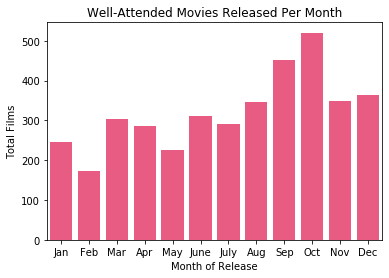

In [51]:
ax = sns.barplot(total_movies_month.index, total_movies_month.values, color="#ff457a")
ax.set(xlabel='Month of Release', ylabel='Total Films')
ax.set_title("Well-Attended Movies Released Per Month")
plt.show()

In [ ]:
p1=sns.boxplot(x=df_watched["month"], y=df_watched["averagerating"], data=df_watched, order=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"], color="steelblue")

In [ ]:
p1=sns.boxplot(x=df_watched["month"], y=df_watched["vote_average"], data=df_watched, order=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"], color="steelblue")

In [ ]:
df_watched["genres"].unique()